In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
from orbitflows.integrate import hamiltonian_fixed_angle, eulerstep
from orbitflows.integrate import rungekutta4 as rk4
from functools import partial 
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H
from time import time

In [2]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

In [3]:
# initialize model
model = HamiltonianMappingModel(targetPotential=isoDiskPotential, input_dim=2, hidden_dim=10, num_layers=4)
model.flow = model.flow.double()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/2701305543.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  plt.scatter(*training_data.T, s=10)



Text(0.5, 1.0, 'Toy Orbits')

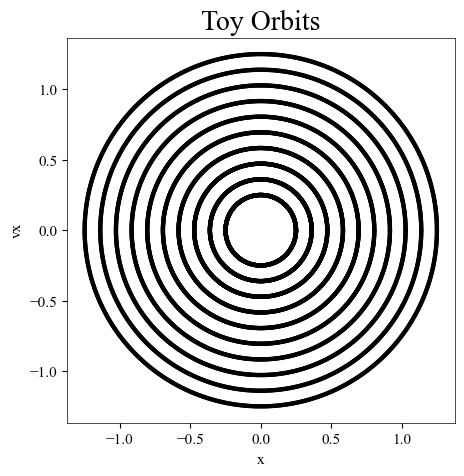

In [4]:
# create training set
n_actions = 10
n_angles = 1000
r_min = 0.25
r_max = 1.25
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=2*np.pi, n_steps=n_angles, r_bounds=[r_min,r_max])
aa_guess = aa_guess.to(torch.float64)
training_data = training_data.to(torch.float64)

# plot training data
plt.figure(figsize=(5, 5))
plt.scatter(*training_data.T, s=10)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

100%|██████████| 500/500 [00:03<00:00, 163.54it/s]


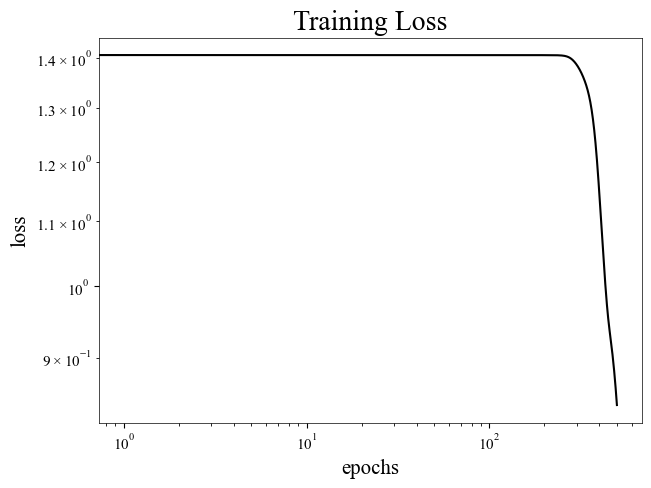

Text(0, 0.5, 'energy')

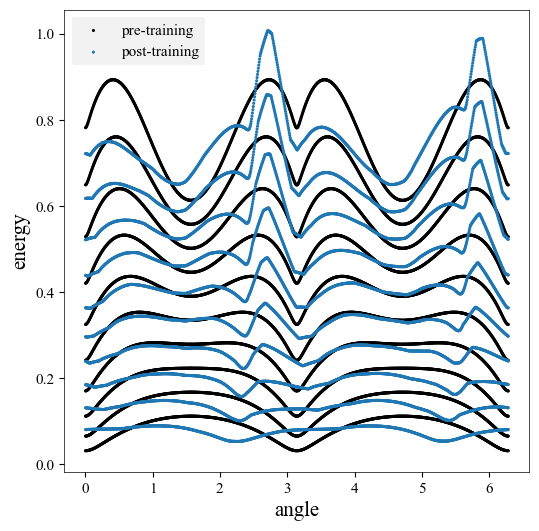

In [5]:
# # train model
steps = 500
model.train(training_data.to(torch.float64), steps, lr=1e-3)

# plot loss
plt.figure(figsize=(7, 5))
plt.loglog(model.loss_list)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title('Training Loss', fontsize=20)
plt.show()

# # plot performance for one orbit
# plt.figure(figsize=(8, 5))
# plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
# plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
# plt.xlabel('time', fontsize=15)
# plt.ylabel('energy', fontsize=15)
# plt.title('model performance', fontsize=20)
# plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6, 6))
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)

So the NF can be thought of as producing a vector field (where each point moves) that we are wanting to appoximate with a spline.

In [31]:
# showing the NF as a vector field
grid_x = np.linspace(-1.5, 1.5, 10)
grid_y = np.linspace(-1.5, 1.5, 10)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)
grid_points = torch.tensor(np.stack([grid_x.flatten(), grid_y.flatten()], axis=1), dtype=torch.float64)
grid_out = model.flow(grid_points)
grid_vectors = grid_out - grid_points

In [32]:
grid_vectors.detach()[:,1].shape

torch.Size([100])

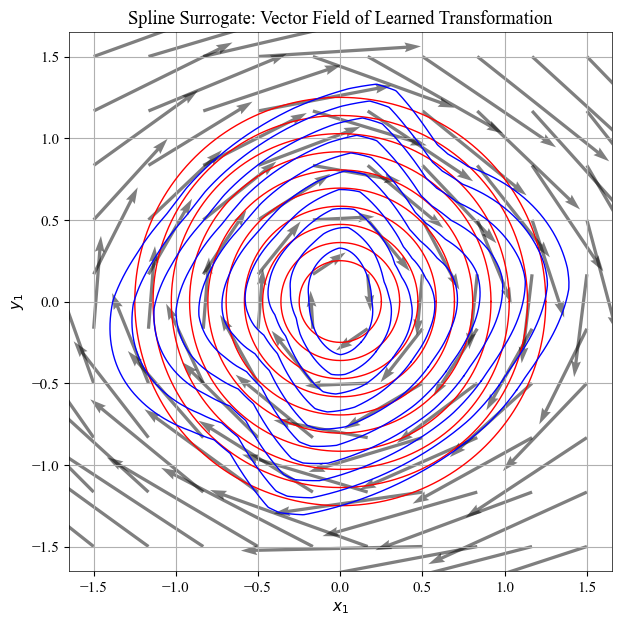

In [33]:
# Plot vector field
plt.figure(figsize=(7, 7))
plt.quiver(*grid_points.detach().T, grid_vectors[:,0].detach(), grid_vectors[:,1].detach(), angles='xy', scale_units='xy', scale=1, color='black', alpha=0.5)
plt.plot(training_data[...,0].detach().T, training_data[...,1].detach().T, color='red', label='training data', lw=1)
plt.plot(model.flow(training_data)[...,0].detach().T, model.flow(training_data)[...,1].detach().T, color='blue', label='training data', lw=1)
#plt.scatter(grid_points[:,0].detach(), grid_points[:,1].detach(), color='black', s=5, label='grid points')
#plt.scatter(model.flow(grid_points)[:,0].detach(), model.flow(grid_points)[:,1].detach(), color='b', s=5, label='grid points')
plt.title("Spline Surrogate: Vector Field of Learned Transformation")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$")
# 
plt.grid(True)
plt.show()

In [273]:
def rbf_kernel(x1, y1, x2, y2, epsilon):
    d2 = (x1[:, None] - x2[None, :])**2 + (y1[:, None] - y2[None, :])**2
    return torch.exp(-d2 / epsilon**2)

class DifferentiableSpline2D:
    def __init__(self, x, y, z, epsilon=0.5, reg=1e-3):
        self.x = x
        self.y = y
        self.z = z
        self.epsilon = epsilon

        K = rbf_kernel(x, y, x, y, epsilon)
        self.coeffs = torch.linalg.solve(K + reg * torch.eye(K.shape[0], dtype=K.dtype), z)

    def __call__(self, xq, yq):
        xq = xq.view(-1)
        yq = yq.view(-1)
        Kq = rbf_kernel(xq, yq, self.x, self.y, self.epsilon)
        return Kq @ self.coeffs
# Fit surrogate splines to x2 and y2
spline_x2 = DifferentiableSpline2D(x1, y1, x2)
spline_y2 = DifferentiableSpline2D(x1, y1, y2)


Input: (0.5, -0.8)
Mapped to: [[-0.0978566]
 [-0.8943712]]
Jacobian:
[[ 0.87776119  0.68927506]
 [-0.45550196  0.81643785]]
/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/2563124145.py:47: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.quiver(*grid_points.T.detach(), x2_grid - grid_points[:,0].detach().numpy(), y2_grid - grid_points[:,1].detach().numpy(), angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/2563124145.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.quiver(*grid_points.T.detach(), x2_grid - grid_points[:,0].detach().numpy(), y2_grid - grid_points[:,1].detach().numpy(), angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)



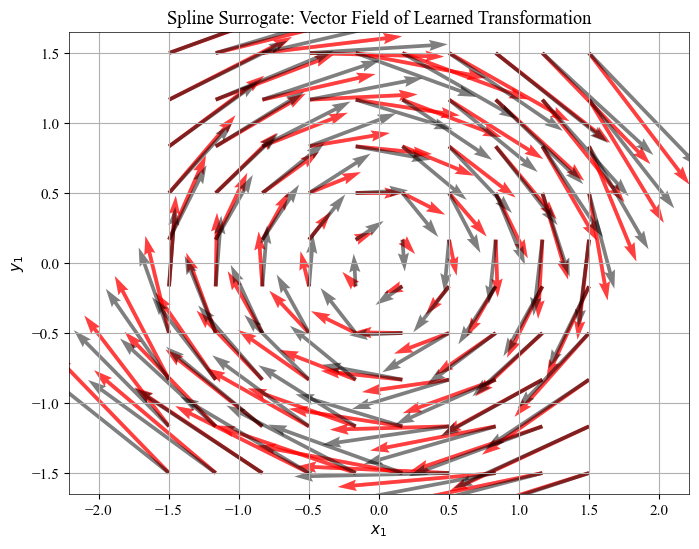

In [274]:
import numpy as np
from scipy.interpolate import SmoothBivariateSpline

# -------------------------------
# 2. Fit smooth spline surrogates
# -------------------------------
# Smoothing parameter (user-controlled!)
s = 10  # Try values like 0.1, 1.0, 10.0

spline_x2 = DifferentiableSpline2D(grid_points[:,0], grid_points[:,1], grid_out[...,0], epsilon=s)
spline_y2 = DifferentiableSpline2D(grid_points[:,0], grid_points[:,1], grid_out[...,1], epsilon=s)

# -------------------------------
# 3. Evaluate map and Jacobian
# -------------------------------
def eval_surrogate_and_jacobian_torch(x, y):
    x = torch.tensor([x], dtype=torch.float64, requires_grad=True)
    y = torch.tensor([y], dtype=torch.float64, requires_grad=True)

    z = torch.stack([spline_x2(x, y), spline_y2(x, y)])  # shape [2]

    J = torch.zeros(2, 2, dtype=torch.float64)
    for i in range(2):
        grad_i = grad(z[i], [x, y], create_graph=True)
        J[i, 0] = grad_i[0]
        J[i, 1] = grad_i[1]

    return z.detach().numpy(), J.detach().numpy()
# Example: evaluate at a new point
pt = (0.5, -0.8)
(z_hat, J_hat) = eval_surrogate_and_jacobian_torch(*pt)

print(f"\nInput: {pt}")
print(f"Mapped to: {z_hat}")
print(f"Jacobian:\n{J_hat}")

# -------------------------------
# 4. Visualize the learned transformation
# -------------------------------
# Create a grid
# Evaluate transformation on grid
x2_grid = spline_x2(*grid_points.T).detach()
y2_grid = spline_y2(*grid_points.T).detach()

# Plot vector field
plt.figure(figsize=(8, 6))
plt.quiver(*grid_points.T.detach(), x2_grid - grid_points[:,0].detach().numpy(), y2_grid - grid_points[:,1].detach().numpy(), angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)
plt.quiver(*grid_points.T.detach(), x2_grid - grid_points[:,0].detach().numpy(), y2_grid - grid_points[:,1].detach().numpy(), angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)
plt.quiver(*grid_points.detach().T, grid_vectors[:,0].detach(), grid_vectors[:,1].detach(), angles='xy', scale_units='xy', scale=1, color='black', alpha=0.5)
plt.title("Spline Surrogate: Vector Field of Learned Transformation")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$")
plt.axis('equal')
plt.grid(True)
plt.show()


In [275]:
def make_splines(grid_points, s):
    grid_out = model.flow(grid_points)
    spline_x2 = DifferentiableSpline2D(grid_points[:,0], grid_points[:,1], grid_out[...,0], epsilon=s)
    spline_y2 = DifferentiableSpline2D(grid_points[:,0], grid_points[:,1], grid_out[...,1], epsilon=s)
    return spline_x2, spline_y2

In [276]:
def spline_transformation(input, xspline, yspline):
    x_out = xspline(*input.reshape(-1, 2).T)
    y_out = yspline(*input.reshape(-1, 2).T)
    return torch.stack([x_out, y_out], dim=-1).reshape(input.shape)

In [277]:
grid_x_fine = np.linspace(-1.5, 1.5, 20)
grid_y_fine = np.linspace(-1.5, 1.5, 20)
grid_x_fine, grid_y_fine = np.meshgrid(grid_x_fine, grid_y_fine)
grid_points_fine = torch.tensor(np.stack([grid_x_fine.flatten(), grid_y_fine.flatten()], axis=1), dtype=torch.float64)

In [278]:
fine_spline_x, fine_spline_y = make_splines(grid_points_fine, s=1.5)

In [279]:
spline_ps = spline_transformation(training_data, fine_spline_x, fine_spline_y)

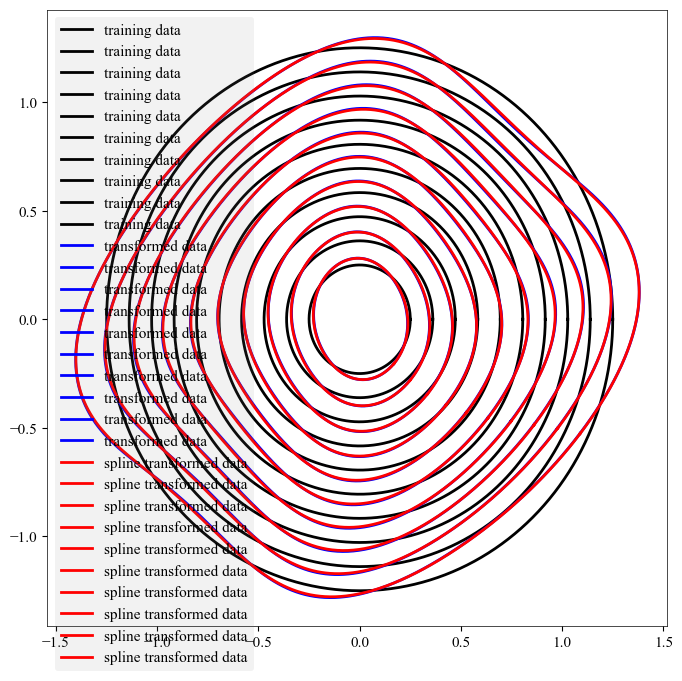

In [280]:
plt.figure(figsize=(8, 8))
plt.plot(training_data[...,0].detach().numpy().T, training_data[...,1].detach().numpy().T, 'k', label='training data', lw=2)
plt.plot(model.flow(training_data)[...,0].detach().numpy().T, model.flow(training_data)[...,1].detach().numpy().T, 'b', label='transformed data', lw=2)
plt.plot(spline_ps[...,0].detach().T, spline_ps[...,1].detach().T, 'r', label='spline transformed data', lw=2)
plt.legend()

## Reassign `flow` to be spline

In [281]:
model.flow = partial(spline_transformation, xspline=fine_spline_x, yspline=fine_spline_y)

In [282]:
def inverse_spline_transformation(output, xspline, yspline, max_iter=50, tol=1e-6):
    # Initialize with the output as initial guess
    input_guess = output.clone()
    
    for i in range(max_iter):
        # Forward pass
        x_out = xspline(*input_guess.reshape(-1, 2).T)
        y_out = yspline(*input_guess.reshape(-1, 2).T)
        forward_output = torch.stack([x_out, y_out], dim=-1).reshape(output.shape)
        
        # Compute residual
        residual = forward_output - output
        
        # Check convergence
        if torch.norm(residual) < tol:
            break
            
        # Newton-Raphson update (simplified)
        input_guess = input_guess - 0.1 * residual
    
    return input_guess

model.flow.inverse = partial(inverse_spline_transformation, xspline=fine_spline_x, yspline=fine_spline_y)

# test orbit integration

In [283]:
# pick initial point for example orbit
aa0 = aa_guess[5][0].requires_grad_(True)
ps0 = model.aa_to_ps(aa0).requires_grad_(True)
H0 = H(ps0, model.targetPotential)

In [284]:
integration_steps = 20
t_end = 10
dt = t_end / integration_steps
st = time()
aa_euler_step = model.integrate(aa0, integration_steps, t_end, hamiltonian_tilde=hamiltonian_fixed_angle, correction=eulerstep).to(torch.float64)
euler_duration = time() - st

100%|██████████| 19/19 [00:00<00:00, 24.58it/s]


In [285]:
rk4_steps = int(integration_steps)
st = time()
aa_rk4 = model.integrate(aa0, rk4_steps, t_end, correction=rk4, hamiltonian_tilde=hamiltonian_fixed_angle).to(torch.float64)
duration_rk4 = time() - st

100%|██████████| 19/19 [00:02<00:00,  7.71it/s]


<>:8: SyntaxWarning: invalid escape sequence '\s'

<>:9: SyntaxWarning: invalid escape sequence '\s'

<>:8: SyntaxWarning: invalid escape sequence '\s'

<>:9: SyntaxWarning: invalid escape sequence '\s'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/2454499456.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s, error={rk4_percent_error:.4f}%, $\sigma =$ {rk4_std:.2e}', alpha=0.75)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/2454499456.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, t_end, integration_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/integration_steps}, duration={euler_duration:.2f}s, error={euler_percent_error:.4f}%, $\sigma =$ {euler_std:.2e}', alpha=0.75)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/2454499456.p

Text(0, 0.5, 'energy')

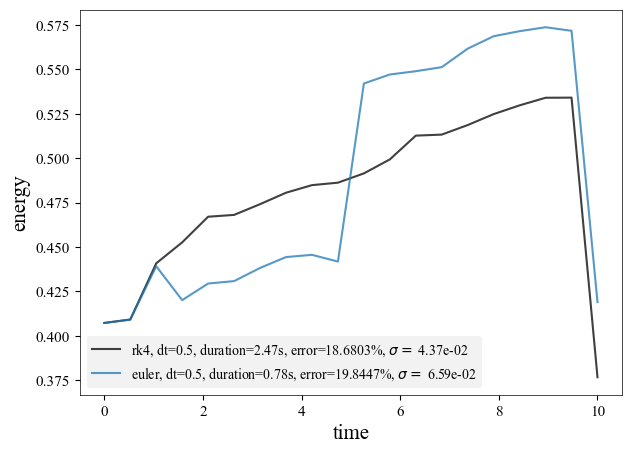

In [286]:
# calculate error
euler_percent_error = np.mean(100 * (np.abs(model.hamiltonian(aa_euler_step).detach() - H0.detach()) /  H0.detach()).numpy())
euler_std = np.std(model.hamiltonian(aa_euler_step).detach().numpy())
rk4_percent_error = np.mean(100 * (np.abs(model.hamiltonian(aa_rk4).detach() - H0.detach()) /H0.detach()).numpy())
rk4_std = np.std(model.hamiltonian(aa_rk4).detach().numpy())

plt.figure(figsize=(7, 5))
plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s, error={rk4_percent_error:.4f}%, $\sigma =$ {rk4_std:.2e}', alpha=0.75)
plt.plot(np.linspace(0, t_end, integration_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/integration_steps}, duration={euler_duration:.2f}s, error={euler_percent_error:.4f}%, $\sigma =$ {euler_std:.2e}', alpha=0.75)
plt.legend(fontsize=10)
plt.xlabel('time', fontsize=15)
plt.ylabel('energy', fontsize=15)

In [296]:
from orbitflows.integrate.correction import dH_dx
from tqdm import tqdm
from galpy.orbit import Orbit
from galpy.potential import IsothermalDiskPotential

In [297]:
ps_start_training = model.aa_to_ps(aa_guess[:,0]).detach().numpy()
o_training = Orbit(ps_start_training)
st = time()
lf_steps = 1000
o_training.integrate(np.linspace(0, t_end, lf_steps), pot=IsothermalDiskPotential(), method='leapfrog')

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/3548670060.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/3548670060.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()



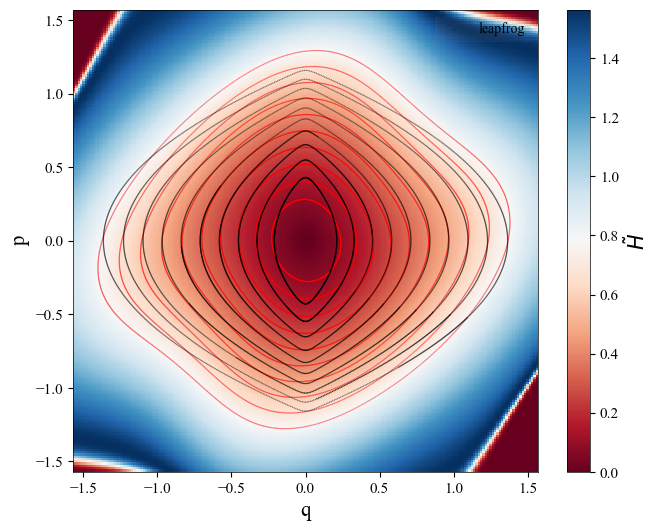

In [298]:
# Determine the range for q (x) and p (vx) from training data
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 200 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')

# Prepare phase-space points for h_error function
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1)

# Calculate h_error for each point in the grid
h_tilde_values = torch.zeros(ps_grid.shape[0])

with torch.no_grad(): # No need to track gradients for plotting
    h_tilde_values = hamiltonian_fixed_angle(model, model.ps_to_aa(ps_grid.to(torch.float64)))

# Reshape error_values to the grid shape
h_tilde_grid = h_tilde_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), h_tilde_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('$\\tilde{H}$', fontsize=15)

plt.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(), model.aa_to_ps(aa_guess)[..., 1].detach().numpy(), c='r', alpha=0.5, s=1)
plt.scatter(o_training.x(o_training.time()), o_training.vx(o_training.time()), c='k', alpha=0.5, s=1, label='leapfrog')
plt.legend(fontsize=10)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.show()

In [301]:
def h_error(model, ps):
    '''
    Compute the error of the model prediction in the Hamiltonian.
    
    Parameters
    ----------
    ps : torch.tensor
        phase-space point
    
    Returns
    -------
    torch.tensor
        Hamiltonian error of the model prediction
    '''
    _aa = model.ps_to_aa(ps)
    return H(ps, model.targetPotential) - hamiltonian_fixed_angle(model, _aa)

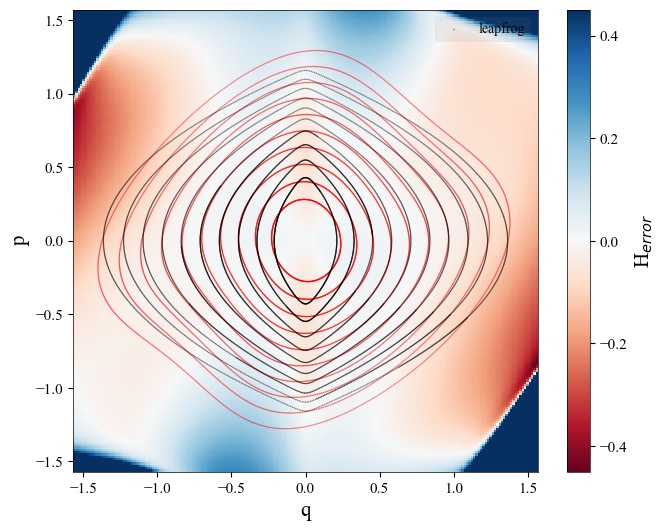

In [302]:
# Calculate h_error for each point in the grid
error_values = torch.zeros(ps_grid.shape[0])

with torch.no_grad(): # No need to track gradients for plotting
    error_values = h_error(model, ps_grid.to(torch.float64))

# Reshape error_values to the grid shape
error_grid = error_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), error_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('H$_{error}$', fontsize=15)
pcm.set_clim(vmin=error_grid.min().item(), vmax=-error_grid.min().item())

plt.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(), model.aa_to_ps(aa_guess)[..., 1].detach().numpy(), c='r', alpha=0.5, s=1)
plt.scatter(o_training.x(o_training.time()), o_training.vx(o_training.time()), c='k', alpha=0.5, s=1, label='leapfrog')
plt.legend(fontsize=10)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.show()

In [303]:
def freq_tilde(model, aa):
    '''
    Compute the frequency of the system using the hamiltonian_tilde function.
    
    Parameters
    ----------
    aa : torch.tensor

            action-angle variables

    Returns
    -------
    torch.tensor
        frequency of the system assuming the hamiltonian_tilde function
    '''
    theta, j = aa[..., 0], aa[..., 1]
    _aa = torch.stack((theta, j), dim=-1)
    return torch.autograd.grad(hamiltonian_fixed_angle(model, _aa), j, allow_unused=True)[0]#hamiltonian_fixed_angle(model, _aa), j, allow_unused=True)[0]

In [304]:
# calculate partial derivatives over a grid in phase space
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 50 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1).to(torch.float64)

dH_dq_grid = []
dH_dp_grid = []
for ps_ in tqdm(ps_grid.requires_grad_()):
    dH_dq_grid.append(dH_dx(ps_, 'q', partial(h_error, model)))
    dH_dp_grid.append(dH_dx(ps_, 'p', partial(h_error, model)))


/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/3237592667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/3237592667.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()



100%|██████████| 2500/2500 [01:16<00:00, 32.60it/s]


In [305]:
# Reshape error_values to the grid shape
dH_dq_grid = torch.tensor(dH_dq_grid).reshape(n_grid_points, n_grid_points)
dH_dp_grid = torch.tensor(dH_dp_grid).reshape(n_grid_points, n_grid_points)

In [306]:
def partials_plot(
        aa,
        stepfunct,
        aa_guess,
        model,
        dH_dq_grid,
        dH_dp_grid,
        freq_tilde,
        training_orbits_correct = True,
        training_orbits_approx = True,
        quivers = True,
        title=''
        ):
        '''
        Plot the partial derivatives of the Hamiltonian error with respect to q and p.
        '''
        fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.075})
        pcm = ax[0].pcolormesh(X.numpy(), VX.numpy(), dH_dq_grid.numpy(), cmap='RdBu', shading='auto')
        pcm2 = ax[1].pcolormesh(X.numpy(), VX.numpy(), dH_dp_grid.numpy(), cmap='RdBu', shading='auto')

        ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)
        ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)

        cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
        plt.colorbar(pcm, cax=cax)
        minmax = torch.abs(torch.tensor([dH_dq_grid.max().item(), dH_dq_grid.min().item(), dH_dp_grid.max().item(), dH_dp_grid.min().item()])).max().item()
        pcm.set_clim(vmin=-minmax, vmax=minmax)
        pcm2.set_clim(vmin=-minmax, vmax=minmax)
        aa0 = aa[0].requires_grad_(True)

        if quivers:
                # drift 1 arrow
                freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in aa]).to(torch.float64) # Shape (n_steps, 2)
                aa_orb_guess = aa.clone().detach() # Shape (n_steps, 2)
                aa_orb_guess[...,0] = aa[..., 0] +  torch.tensor(freq_tildes) * dt/2
                nf_prediction_ps = model.aa_to_ps(aa_orb_guess.to(torch.float64)) # Shape (n_steps, 2)
                qp_quiver = model.aa_to_ps(aa)
                q_plot_quiver = qp_quiver[..., 0]
                p_plot_quiver = qp_quiver[..., 1]
                delta_q_guess = nf_prediction_ps[..., 0] - q_plot_quiver
                delta_p_guess = nf_prediction_ps[..., 1] - p_plot_quiver

                # kick arrow
                q_plot_quiver_2 = []
                p_plot_quiver_2 = []
                delta_q_guess_2 = []
                delta_p_guess_2 = []
                for i, qp in enumerate(nf_prediction_ps):
                        new_ps = stepfunct(qp, dt, partial(h_error, model))
                        q_plot_quiver_2.append(new_ps[0].detach().item())
                        p_plot_quiver_2.append(new_ps[1].detach().item())
                        delta_q_guess_2.append((new_ps[0] - qp[0]).detach()) #nf_prediction_ps[..., 0] - q_plot_quiver_2
                        delta_p_guess_2.append((new_ps[1] - qp[1]).detach()) # nf_prediction_ps[..., 1] - p_plot_quiver_2

                q_plot_quiver_2 = torch.tensor(q_plot_quiver_2).to(torch.float64)
                p_plot_quiver_2 = torch.tensor(p_plot_quiver_2).to(torch.float64)


                # drift 2 arrow
                new_aa = model.ps_to_aa(torch.stack((q_plot_quiver_2, p_plot_quiver_2), dim=-1))
                new_freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in new_aa]).to(torch.float64)
                drift_2_aa = new_aa.clone().detach()
                drift_2_aa[..., 0] = new_aa[..., 0] +  torch.tensor(new_freq_tildes) * dt/2
                drift_2_ps = model.aa_to_ps(drift_2_aa.to(torch.float64))
                delta_q_guess_drift2 = drift_2_ps[..., 0] -  q_plot_quiver_2
                delta_p_guess_drift2 = drift_2_ps[..., 1] - p_plot_quiver_2

        ex_orb = aa0.repeat(len(aa_guess[0][...,0]), 1)
        ex_orb[...,0] = aa_guess[0][...,0].detach()

        for axi in ax:
                if training_orbits_correct:
                        axi.scatter(o_training.x(o_training.time()), o_training.vx(o_training.time()), c='k', s=1, alpha=0.25)
                        axi.scatter(o_training.x(o_training.time())[5], o_training.vx(o_training.time())[5], c='teal', s=3, alpha=1)
                if training_orbits_approx:
                        axi.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(),
                                model.aa_to_ps(aa_guess)[..., 1].detach().numpy(),
                                c='r', alpha=0.25, s=1)
                        axi.plot(*model.aa_to_ps(aa).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=1)
                        axi.scatter(*model.aa_to_ps(aa).T.detach().numpy(), c='b', alpha=0.75, s=20)
                if quivers:
                        # arrows
                        axi.quiver(q_plot_quiver[:-1].detach().numpy(), p_plot_quiver[:-1].detach().numpy(),
                                delta_q_guess.detach().numpy()[:-1], delta_p_guess.detach().numpy()[:-1],
                                angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=1,
                                label=f'drift')
                        axi.quiver(nf_prediction_ps[..., 0][:-1].detach().numpy(), nf_prediction_ps[..., 1][:-1].detach().numpy(),
                                delta_q_guess_2[:-1], delta_p_guess_2[:-1],
                                angles='xy', scale_units='xy', scale=1, color='r', width=0.005, alpha=1,
                                label=f'kick')
                        axi.quiver(q_plot_quiver_2[:-1].detach().numpy(), p_plot_quiver_2[:-1].detach().numpy(),
                                delta_q_guess_drift2.detach().numpy()[:-1], delta_p_guess_drift2.detach().numpy()[:-1],
                                angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=1,
                                label=f'drift')
        
        
                axi.scatter(*ps0.detach(), c='cyan')

        ax[1].annotate('q', xy=(-0.04, -0.15), xycoords='axes fraction', ha='center', fontsize=20)
        ax[0].annotate('p', xy=(-0.15, 0.5), xycoords='axes fraction', ha='center', fontsize=20, rotation='vertical')
        ax[0].set_xlim(-1.5, 1.5)
        ax[0].set_ylim(-1.5, 1.5)
        ax[1].legend(fontsize=10, loc='upper right')
        ax[1].annotate(title, xy=(-0.04, 1.2), xycoords='axes fraction', ha='center', fontsize=20)

        return fig, ax

<>:21: SyntaxWarning: invalid escape sequence '\p'

<>:22: SyntaxWarning: invalid escape sequence '\p'

<>:21: SyntaxWarning: invalid escape sequence '\p'

<>:22: SyntaxWarning: invalid escape sequence '\p'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/1407300018.py:21: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/1407300018.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)



/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/1407300018.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_orb_guess[...,0] = aa[..., 0] +  torch.tensor(freq_tildes) * dt/2

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/1407300018.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift_2_aa[..., 0] = new_aa[..., 0] +  torch.tensor(new_freq_tildes) * dt/2



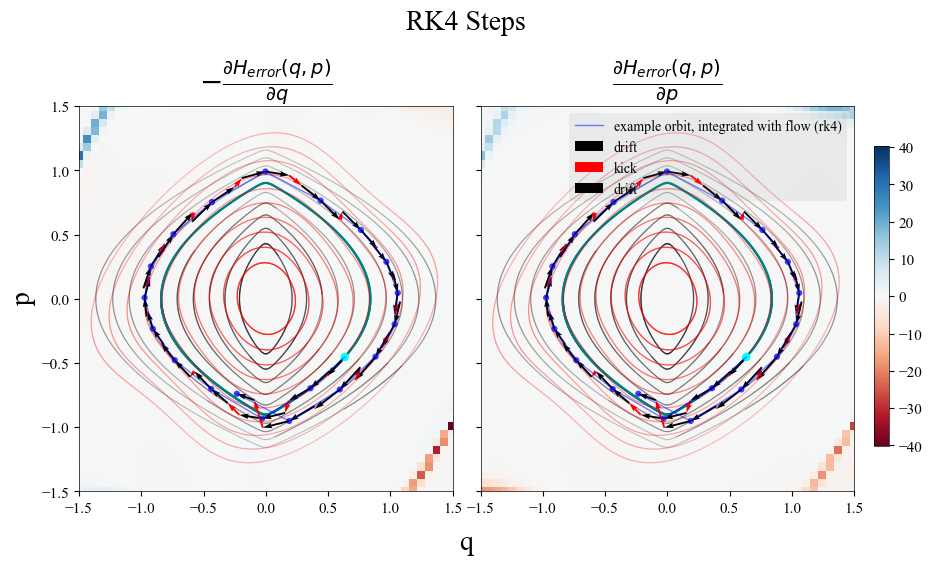

In [307]:
fig_rk4, ax_rk4 = partials_plot(aa_rk4, rk4, aa_guess, model, dH_dq_grid, dH_dp_grid, freq_tilde, title='RK4 Steps')

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/1407300018.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_orb_guess[...,0] = aa[..., 0] +  torch.tensor(freq_tildes) * dt/2

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_22068/1407300018.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drift_2_aa[..., 0] = new_aa[..., 0] +  torch.tensor(new_freq_tildes) * dt/2



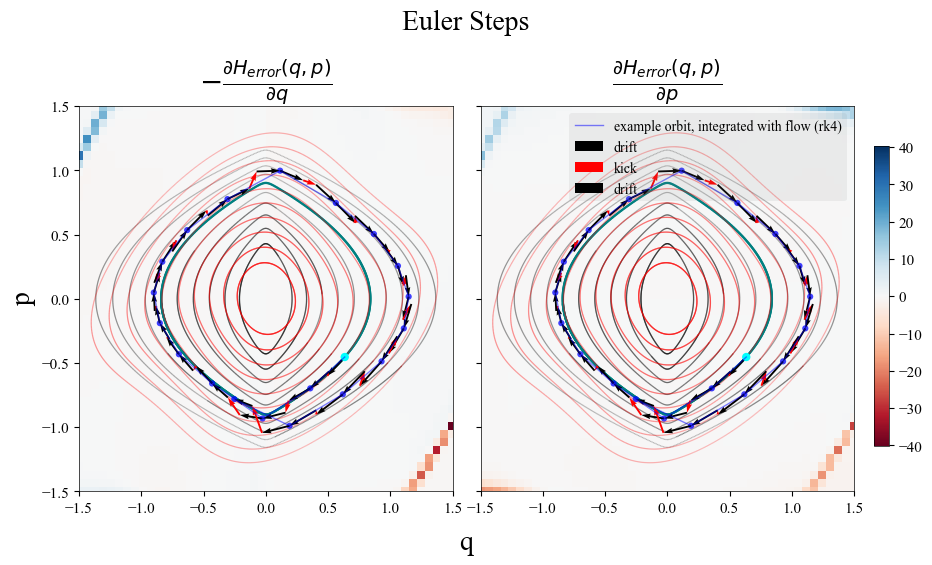

In [308]:
fig_euler, ax_euler = partials_plot(aa_euler_step, eulerstep, aa_guess, model, dH_dq_grid, dH_dp_grid, freq_tilde, title='Euler Steps')